In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/facial-keypoints-detection"))

# Any results you write to the current directory are saved as output.

['IdLookupTable.csv', 'test', 'SampleSubmission.csv', 'training']


In [2]:
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

FTRAIN = '../input/facial-keypoints-detection/training/training.csv'
FTEST = '../input/facial-keypoints-detection/test/test.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [3]:
#  I changed the X dimension structure to have (Nsample, Nrows in frame, N columns in frame, 1) in load2d.
def load2d(test=False,cols=None):

    re = load(test, cols)
    
    X = re[0].reshape(-1,96,96,1)
    y = re[1]

    return X, y

In [4]:
#A Fully connected model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.layers import Dropout

model = Sequential()
model.add(Dense(128,input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(30))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1950      
Total params: 1,189,982
Trainable params: 1,189,982
Non-trainable params: 0
____________________________________________

In [5]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

hist = model.fit(X, y, epochs=50,batch_size=128, validation_split=0.2,verbose=False)

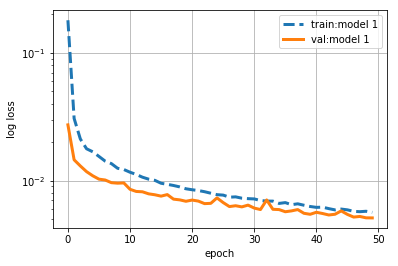

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plot_loss(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [7]:
X_test, _ = load(test=True)
y_test = model.predict(X_test)

ImageId    1783
Image      1783
dtype: int64


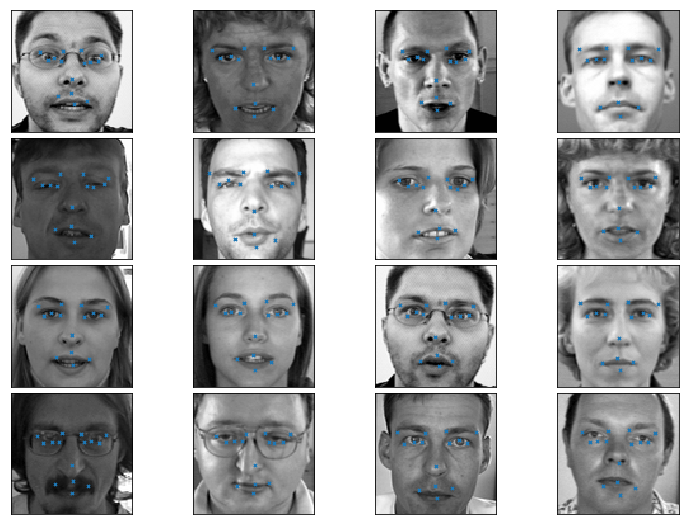

In [8]:
#convert the images back to 96*96 pixels so i can check the performance of my model on the image dataset

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)


fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

plt.show()

In [9]:
from keras.models import load_model
# import h5py
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
model = load_model('my_model.h5')

In [10]:
X.shape

(2140, 9216)

In [11]:
#Convolutional Neural Network
X,y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [12]:
print(X.shape)
print(y.shape)

(2140, 96, 96, 1)
(2140, 30)


In [13]:
from keras.layers import MaxPooling2D, Conv2D , Flatten, Dropout
from keras.layers.normalization import BatchNormalization
def CNN():
    model2 = Sequential()

    model2.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(96,96,1)))
    model2.add(Dropout(0.1))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
    model2.add(BatchNormalization())

    model2.add(Conv2D(32, 5, 5,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
    model2.add(Dropout(0.2))
    model2.add(BatchNormalization())

    model2.add(Conv2D(64, 5, 5,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
    model2.add(BatchNormalization())

    model2.add(Conv2D(128, 3, 3,activation="relu"))
    # model.add(Activation("relu"))
    model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
    model2.add(Dropout(0.4))
    model2.add(BatchNormalization())

    model2.add(Flatten())

    model2.add(Dense(500, activation="relu"))
    model2.add(Dropout(0.1))

    model2.add(Dense(128, activation="relu"))
    model2.add(Dropout(0.1))

    model2.add(Dense(30))


    model2.summary()
    model2.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae','accuracy'])
    return(model2)

model2 = CNN()
hist2 = model2.fit(X, y, epochs=500,batch_size=128, validation_split=0.2,verbose=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
/opt/c

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 22, 32)       

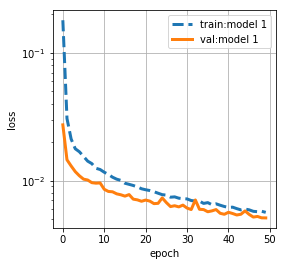

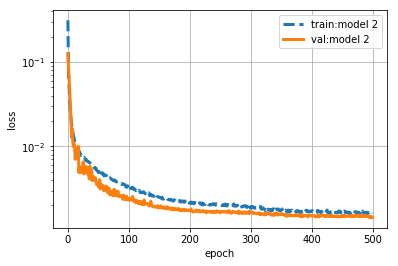

In [14]:
# Comparing model1 and model2
plt.figure(figsize=(4,4))
plot_loss(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plot_loss(hist2.history,"model 2",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [15]:
sample1,_ = load(test=True)
sample2,_ = load2d(test=True)
y_pred1 = model.predict(sample1)
y_pred2 = model2.predict(sample2)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


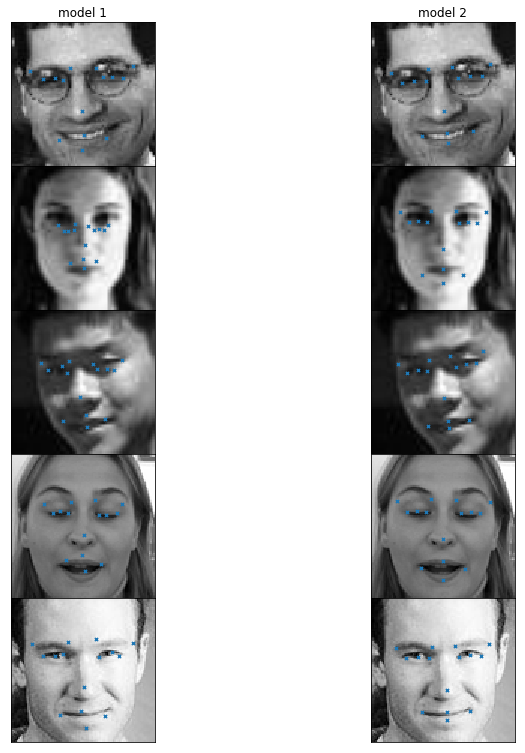

In [16]:
#Comparing model1 and model2 on images

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.001,wspace=0.001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 5
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(sample2.shape[0])
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])        
    plot_sample(sample1[ipic],y_pred1[ipic],ax)
    if count < 3:
        ax.set_title("model 1")
        
    count += 1
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])  
    plot_sample(sample2[ipic],y_pred2[ipic],ax)
    if count < 3:
        ax.set_title("model 2")
    count += 1
plt.show()

In [17]:
model2.save('my_model2.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
model2 = load_model('my_model2.h5')

In [18]:
## Using ImageDataGenerator to flip the images and flip indices will be used to manually flipping
## the keypoints on the face

from keras.preprocessing.image import ImageDataGenerator
class FlippedImageDataGenerator(ImageDataGenerator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]

        if y_batch is not None:
            
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            # left_eye_center_x -> right_eye_center_x のようにフリップ
            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch

In [19]:
## splitting the data
from sklearn.model_selection import train_test_split

X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [20]:
model3 = CNN()
flipgen = FlippedImageDataGenerator()
hist3 = model3.fit_generator(flipgen.flow(X_train, y_train),
                             samples_per_epoch=X_train.shape[0],
                             nb_epoch=300,
                             validation_data=(X_val, y_val))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu")`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
/opt/c

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
dropout_7 (Dropout)          (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 22, 32)       

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=53, epochs=300)`
  


Epoch 1/300
53/53 [==============================] - 2s 32ms/step - loss: 0.1349 - mae: 0.2602 - accuracy: 0.1774 - val_loss: 0.0732 - val_mae: 0.2249 - val_accuracy: 0.2593
Epoch 2/300
53/53 [==============================] - 1s 14ms/step - loss: 0.0285 - mae: 0.1295 - accuracy: 0.4185 - val_loss: 0.0266 - val_mae: 0.1321 - val_accuracy: 0.2593
Epoch 3/300
53/53 [==============================] - 1s 14ms/step - loss: 0.0173 - mae: 0.0980 - accuracy: 0.4935 - val_loss: 0.0129 - val_mae: 0.0890 - val_accuracy: 0.4579
Epoch 4/300
53/53 [==============================] - 1s 13ms/step - loss: 0.0132 - mae: 0.0842 - accuracy: 0.5321 - val_loss: 0.0060 - val_mae: 0.0589 - val_accuracy: 0.6916
Epoch 5/300
53/53 [==============================] - 1s 14ms/step - loss: 0.0112 - mae: 0.0764 - accuracy: 0.5845 - val_loss: 0.0059 - val_mae: 0.0571 - val_accuracy: 0.6916
Epoch 6/300
53/53 [==============================] - 1s 14ms/step - loss: 0.0100 - mae: 0.0729 - accuracy: 0.6506 - val_loss: 0.00

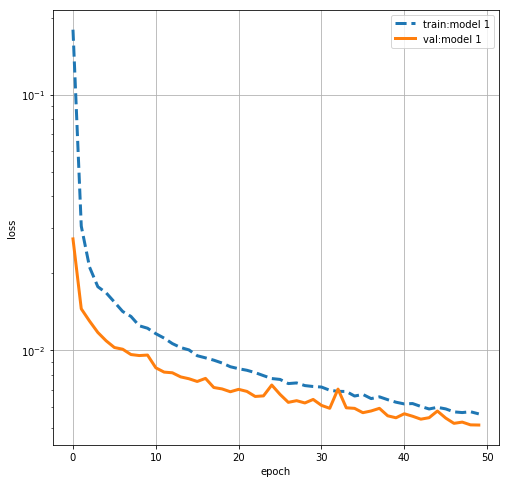

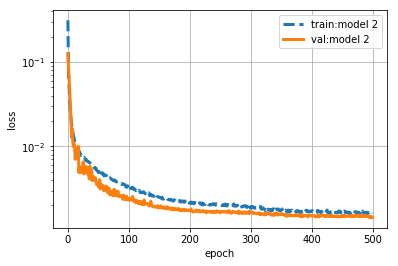

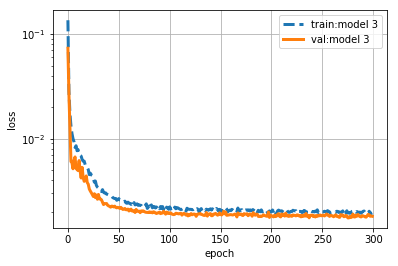

In [21]:
## Comparing mode1, model2 and model3 using pyplot
plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plot_loss(hist2.history,"model 2",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plot_loss(hist3.history,"model 3",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [22]:
X_train.shape

(1712, 96, 96, 1)

In [23]:
model3.save('my_model3.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
model3 = load_model('my_model3.h5')

In [24]:
##Specialist Settings
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

In [25]:
#Training special model with model3
from collections import OrderedDict

def fit_specialists(freeze=True,
                    print_every=10,
                    epochs=100,
                    prop=0.1,
                    name_transfer_model="my_model3.h5"):
    specialists = OrderedDict()
 

    for setting in SPECIALIST_SETTINGS:
        
        cols = setting['columns']
        flip_indices = setting['flip_indices']
        
        X, y = load2d(cols=cols)
        X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
        model4 = load_model(name_transfer_model) 
        if freeze:
            for layer in model.layers:
                layer.trainable = False
            
        model4.layers.pop() # get rid of output layer
        model4.outputs = [model4.layers[-1].output]
        model4.layers[-1].outbound_nodes = []
        model4.add(Dense(len(cols))) # add new output layer

        model4.compile(loss='mean_squared_error', optimizer="adam")
        
        flipgen = FlippedImageDataGenerator()
        flipgen.flip_indices = setting['flip_indices']
        print(X_train.shape)
        print(y_train.shape)
        print(X_val.shape)
        print(y_val.shape)
        hist_final = model4.fit_generator(flipgen.flow(X_train, y_train),
                                     samples_per_epoch=X_train.shape[0],
                                     nb_epoch=epochs,
                                     validation_data=(X_val, y_val))
        
        ## print(model.summary()) 
        
       
        specialists[cols] = model4
    return(specialists)

In [26]:
specialists1 = fit_specialists(freeze=True,
                    print_every=10,
                    epochs=100,
                    name_transfer_model="my_model3.h5")

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
(5626, 96, 96, 1)
(5626, 4)
(1407, 96, 96, 1)
(1407, 4)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=175, epochs=100)`


Epoch 1/100
175/175 [==============================] - 4s 22ms/step - loss: 0.0195 - val_loss: 0.0044
Epoch 2/100
175/175 [==============================] - 2s 13ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 3/100
175/175 [==============================] - 2s 13ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 4/100
175/175 [==============================] - 2s 13ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 5/100
175/175 [==============================] - 2s 13ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 6/100
175/175 [==============================] - 2s 13ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 7/100
175/175 [==============================] - 2s 13ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 8/100
175/175 [==============================] - 2s 13ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 9/100
175/175 [==============================] - 2s 13ms/step - loss: 0.0017 - val_loss: 0.0117
Epoch 10/100
175/175 [==============================] - 2s 13ms/step - loss: 0.002

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=176, epochs=100)`


Epoch 1/100
176/176 [==============================] - 4s 25ms/step - loss: 0.0385 - val_loss: 0.0058
Epoch 2/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 3/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 4/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0053 - val_loss: 0.0072
Epoch 5/100
176/176 [==============================] - 3s 14ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 6/100
176/176 [==============================] - 3s 14ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 7/100
176/176 [==============================] - 3s 14ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 8/100
176/176 [==============================] - 3s 14ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 9/100
176/176 [==============================] - 3s 14ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 10/100
176/176 [==============================] - 3s 14ms/step - loss: 0.003

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=56, epochs=100)`


Epoch 1/100
56/56 [==============================] - 3s 54ms/step - loss: 0.0378 - val_loss: 0.0062
Epoch 2/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 3/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 4/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 5/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 6/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0038 - val_loss: 0.0268
Epoch 8/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 9/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 10/100
56/56 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0018

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=175, epochs=100)`


Epoch 1/100
175/175 [==============================] - 5s 28ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 2/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 4/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 5/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 8/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/100
175/175 [==============================] - 3s 14ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 10/100
175/175 [==============================] - 2s 14ms/step - loss: 0.002

In [27]:
X_train.shape

(1712, 96, 96, 1)

In [28]:
type(specialists1)

collections.OrderedDict

In [29]:
from pandas import DataFrame, concat

X_test,_ = load2d(test=True)

## prediction with model 3
y_pred3 = model3.predict(X_test)
landmark_nm = read_csv(os.path.expanduser(FTRAIN)).columns[:-1].values
df_y_pred3 = DataFrame(y_pred3,columns = landmark_nm)

## prediction with specialist model
def predict_specialist(specialists1,X_test):
    y_pred_s = []
    for columns, value in specialists1.items():
        smodel = value

        y_pred = smodel.predict(X_test)
        y_pred = DataFrame(y_pred,columns=columns)
        y_pred_s.append(y_pred)

    df_y_pred_s = concat(y_pred_s,axis=1)
    return(df_y_pred_s)
df_y_pred_s = predict_specialist(specialists1,X_test)
y_pred_s = df_y_pred_s.values

ImageId    1783
Image      1783
dtype: int64


In [30]:
#Creating submission files for both the models
FIdLookup = '../input/facial-keypoints-detection/IdLookupTable.csv'

IdLookup = read_csv(os.path.expanduser(FIdLookup))

def prepare_submission(y_pred4,filename):
    '''
    save a .csv file that can be submitted to kaggle
    '''
    ImageId = IdLookup["ImageId"]
    FeatureName = IdLookup["FeatureName"]
    RowId = IdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,y_pred4[landmark].iloc[irow-1]])
    
    submit = DataFrame(submit,columns=["RowId","Location"])
    ## adjust the scale 
    submit["Location"] = submit["Location"]*48 + 48
    print(submit.shape)
#     loc = "result/" + filename + ".csv"
    if filename == "model3":
       submit.to_csv("model3.csv",index=False) 
    else:
        submit.to_csv("special.csv",index=False)
    
#     print("File is saved at:" +  loc)

prepare_submission(df_y_pred_s,"special")    
prepare_submission(df_y_pred3,"model3")

(27124, 2)
(27124, 2)


In [31]:
df_y_pred_s = df_y_pred_s[df_y_pred3.columns]
df_compare = {}
df_compare["difference"] = ((df_y_pred_s - df_y_pred3)**2).mean(axis=1)
df_compare["RowId"] = range(df_y_pred_s.shape[0])
df_compare = DataFrame(df_compare)
df_compare = df_compare.sort_values("difference",ascending=False)

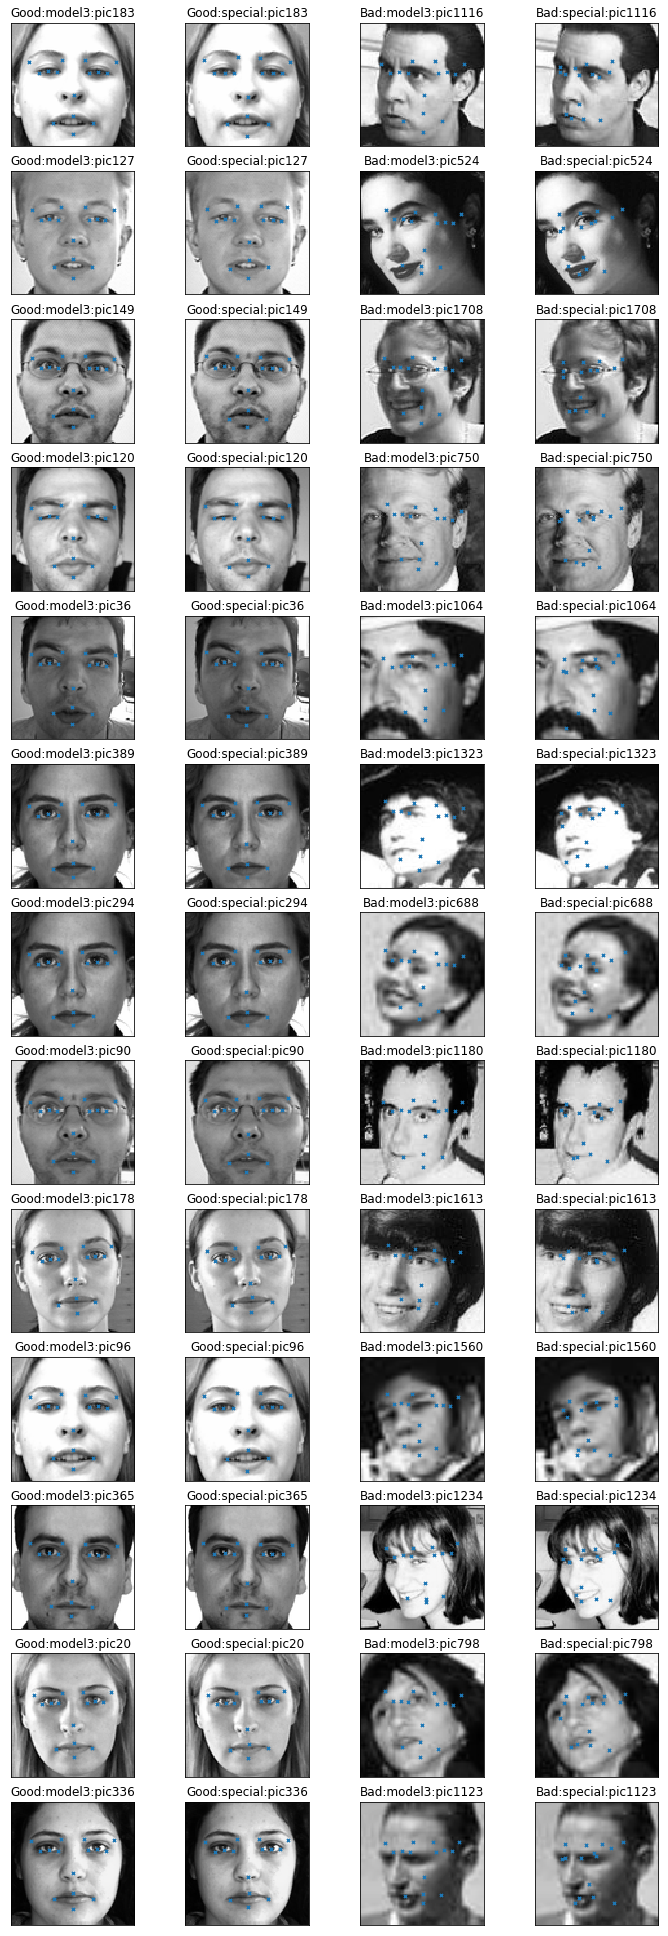

In [32]:
fig = plt.figure(figsize=(12,35))

Nsample = 13
pic_index = df_compare["RowId"].iloc[:Nsample].values
pic_index_good = df_compare["RowId"].iloc[-Nsample:].values
count = 1


for ipic_g,ipic in zip(pic_index_good,pic_index):
    ## good model 3
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred3[ipic_g],ax)
    ax.set_title("Good:model3:pic"+str(ipic_g))
    
    ## good special
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred_s[ipic_g],ax)
    ax.set_title("Good:special:pic"+str(ipic_g))
    
    ## bad model 3
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred3[ipic],ax)
    ax.set_title("Bad:model3:pic"+str(ipic))
    
    ## bad special
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s[ipic],ax)
    ax.set_title("Bad:special:pic"+str(ipic))

plt.show()

In [33]:
#Training special model with model2
def fit_specialists(freeze=True,
                    print_every=10,
                    epochs=100,
                    prop=0.1,
                    name_transfer_model="my_model2.h5"):
    specialists = OrderedDict()
 

    for setting in SPECIALIST_SETTINGS:
        
        cols = setting['columns']
        flip_indices = setting['flip_indices']
        
        X, y = load2d(cols=cols)
        X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
        model4 = load_model(name_transfer_model) 
        if freeze:
            for layer in model.layers:
                layer.trainable = False
            
        model4.layers.pop() # get rid of output layer
        model4.outputs = [model4.layers[-1].output]
        model4.layers[-1].outbound_nodes = []
        model4.add(Dense(len(cols))) # add new output layer

        model4.compile(loss='mean_squared_error', optimizer="adam")
        
        flipgen = FlippedImageDataGenerator()
        flipgen.flip_indices = setting['flip_indices']
        
        print(X_train.shape)
        print(y_train.shape)
        print(X_val.shape)
        print(y_val.shape)
        
        hist_final = model4.fit_generator(flipgen.flow(X_train, y_train),
                                     samples_per_epoch=X_train.shape[0],
                                     nb_epoch=epochs,
                                     validation_data=(X_val, y_val))
        
        
       
        specialists[cols] = model4
    return(specialists)

In [34]:
specialists2 = fit_specialists(freeze=True,
                    print_every=10,
                    epochs=100,
                    name_transfer_model="my_model2.h5")

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
(5626, 96, 96, 1)
(5626, 4)
(1407, 96, 96, 1)
(1407, 4)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=175, epochs=100)`


Epoch 1/100
175/175 [==============================] - 6s 33ms/step - loss: 0.0301 - val_loss: 0.0056
Epoch 2/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 3/100
175/175 [==============================] - 2s 14ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 4/100
175/175 [==============================] - 3s 14ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 5/100
175/175 [==============================] - 3s 14ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 6/100
175/175 [==============================] - 3s 14ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 7/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 8/100
175/175 [==============================] - 3s 14ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 9/100
175/175 [==============================] - 3s 14ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 10/100
175/175 [==============================] - 3s 14ms/step - loss: 0.002

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=176, epochs=100)`


Epoch 1/100
176/176 [==============================] - 6s 35ms/step - loss: 0.0298 - val_loss: 0.0069
Epoch 2/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 3/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 4/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 5/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 6/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 7/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 8/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0042 - val_loss: 0.0151
Epoch 9/100
176/176 [==============================] - 3s 15ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 10/100
176/176 [==============================] - 3s 15ms/step - loss: 0.004

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=56, epochs=100)`


Epoch 1/100
56/56 [==============================] - 5s 89ms/step - loss: 0.0634 - val_loss: 0.0112
Epoch 2/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0135 - val_loss: 0.0068
Epoch 3/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0101 - val_loss: 0.0049
Epoch 4/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 5/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0060 - val_loss: 0.0037
Epoch 6/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 7/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 8/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 9/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 10/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0030 - val_loss: 0.0028

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., steps_per_epoch=175, epochs=100)`


Epoch 1/100
175/175 [==============================] - 7s 39ms/step - loss: 0.0309 - val_loss: 0.0076
Epoch 2/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 3/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 4/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 5/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 6/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 7/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 8/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/100
175/175 [==============================] - 3s 15ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/100
175/175 [==============================] - 3s 15ms/step - loss: 0.003

In [35]:
X_test,_ = load2d(test=True)

def predict_specialist(specialists2,X_test):
    y_pred_s = []
    for columns, value in specialists2.items():
        smodel = value

        y_pred = smodel.predict(X_test)
        y_pred = DataFrame(y_pred,columns=columns)
        y_pred_s.append(y_pred)

    df_y_pred_s = concat(y_pred_s,axis=1)
    return(df_y_pred_s)
df_y_pred_s = predict_specialist(specialists2,X_test)
y_pred_s = df_y_pred_s.values

ImageId    1783
Image      1783
dtype: int64


In [36]:
## prediction with model 2
y_pred2 = model2.predict(X_test)
landmark_nm = read_csv(os.path.expanduser(FTRAIN)).columns[:-1].values
df_y_pred2 = DataFrame(y_pred2,columns = landmark_nm)

In [37]:
#Creating submission files for both the models
FIdLookup = '../input/facial-keypoints-detection/IdLookupTable.csv'

IdLookup = read_csv(os.path.expanduser(FIdLookup))

def prepare_submission(y_pred2,filename):
    '''
    save a .csv file that can be submitted to kaggle
    '''
    ImageId = IdLookup["ImageId"]
    FeatureName = IdLookup["FeatureName"]
    RowId = IdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,y_pred2[landmark].iloc[irow-1]])
    
    submit = DataFrame(submit,columns=["RowId","Location"])
    ## adjust the scale 
    submit["Location"] = submit["Location"]*48 + 48
    print(submit.shape)

    if filename == "model2":
        submit.to_csv("model2.csv",index=False) 
    else:
        submit.to_csv("special_model2.csv",index=False)
    

prepare_submission(df_y_pred_s,"special_model2")    
prepare_submission(df_y_pred2,"model2")

(27124, 2)
(27124, 2)


In [38]:
df_y_pred_s = df_y_pred_s[df_y_pred3.columns]
df_compare = {}
df_compare["difference"] = ((df_y_pred_s - df_y_pred2)**2).mean(axis=1)
df_compare["RowId"] = range(df_y_pred_s.shape[0])
df_compare = DataFrame(df_compare)
df_compare = df_compare.sort_values("difference",ascending=False)

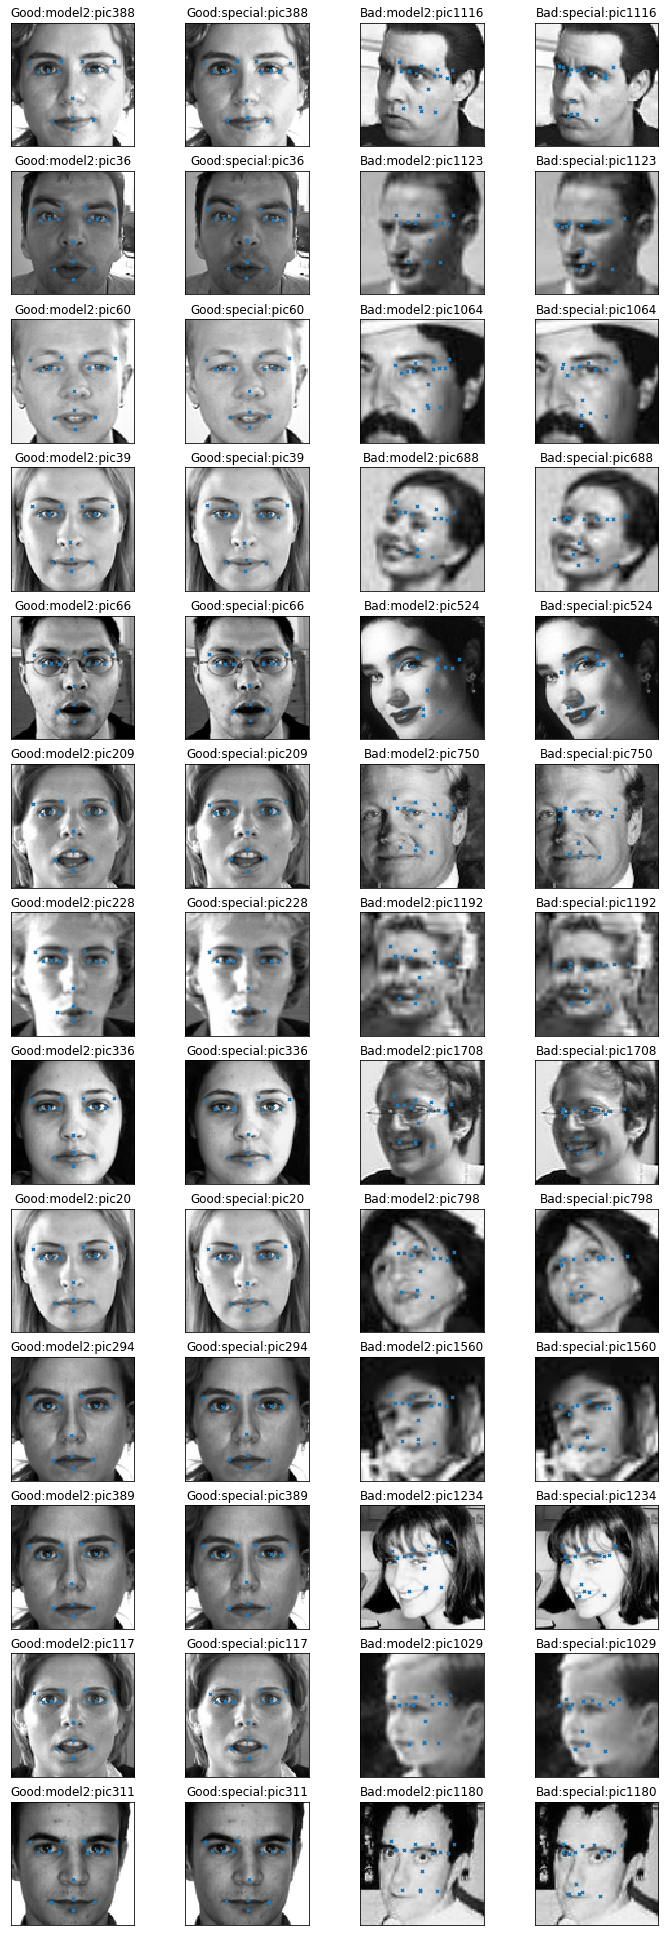

In [39]:
fig = plt.figure(figsize=(12,35))

Nsample = 13
pic_index = df_compare["RowId"].iloc[:Nsample].values
pic_index_good = df_compare["RowId"].iloc[-Nsample:].values
count = 1


for ipic_g,ipic in zip(pic_index_good,pic_index):
    ## good model 2
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred2[ipic_g],ax)
    ax.set_title("Good:model2:pic"+str(ipic_g))
    
    ## good special
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred_s[ipic_g],ax)
    ax.set_title("Good:special:pic"+str(ipic_g))
    
    ## bad model 2
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred2[ipic],ax)
    ax.set_title("Bad:model2:pic"+str(ipic))
    
    ## bad special
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s[ipic],ax)
    ax.set_title("Bad:special:pic"+str(ipic))

plt.show()